In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm

import matplotlib as mpl

In [2]:
ts = pd.read_hdf('timescales.h5', key='timescales')
chosen_lags = pd.read_hdf('chosen_lag_times.h5', key='chosen_lags')

In [3]:
lags_dict = dict(zip(chosen_lags['protein'], chosen_lags['lag']))
lags_dict

{'BBA': 40.0,
 'BBL': 40.0,
 'Chignolin': 20.0,
 'Homeodomain': 20.0,
 'Protein-B': 40.0,
 'Trp-cage': 20.0,
 'Villin': 30.0,
 'WW-domain': 40.0}

In [4]:
ts['chosen_lag'] = ts['protein'].apply(lambda x: lags_dict[x])
ts = ts.loc[ts.lag==ts.chosen_lag, :]
del ts['chosen_lag']

In [7]:
ts_df = ts.loc[:, ['num_its', 'value', 'hp_index', 'protein', 'iteration']]
ts_df.sort_values(by=['protein', 'hp_index', 'iteration', 'num_its'], inplace=True)

ts_df.head()
denom='one'
use_log = True

ts_df = funcs.timescale_gradient(ts_df, x='num_its', log=use_log, denom=denom)
ts_df = ts_df.groupby(['protein', 'hp_index', 'num_its'], as_index=False).median()

ts_df['grad_t'] = np.abs(ts_df['grad_t'])
ts_df['num_its'] -= 1
ts_df['rank'] = ts_df.groupby(['protein', 'hp_index'], as_index=False)['grad_t'].rank(ascending=False)
ts_df['num_its'] = ts_df['num_its'].astype(int).astype('category')

In [8]:
gap_rank_threshold = 1.0
top_ts = ts_df.loc[ts_df['rank'] == gap_rank_threshold, :]


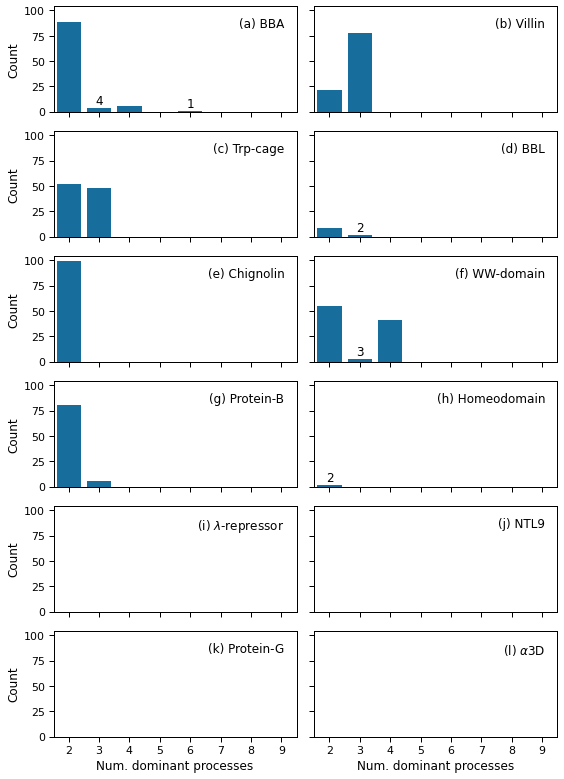

In [9]:
with sns.plotting_context('paper', font_scale=1.25):
    n_rows, n_cols = 6, 2
    sharey=True
    use_log = True # percentage change in timescale as gradient
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

        
    ylabel = 'Count'
    xlabel = 'Num. dominant processes'
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            tmp = top_ts.loc[top_ts.protein==label, :]
            
            
            if tmp.shape[0]>1:
                sns.countplot(data=tmp, x='num_its',  order=np.arange(2, 10).astype(int), 
                                   color=funcs.cols[0], ax=ax)
                ax.set_ylabel(None)
                ax.set_xlabel(None)
                
                heights = [x.get_height() for x in ax.containers[0]]
                labels = [int(x) if x < 5 else '' for x in heights]
                ax.bar_label(ax.containers[0], labels)
                
                
            if sharey:
                if j == 0:
                    ax.set_ylabel(ylabel)
            else:
                ax.set_ylabel(ylabel)

            if i == n_rows - 1:
                ax.set_xlabel(xlabel)
            

            ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.95, 0.9), 
                        xycoords='axes fraction', ha='right', va='top', 
                       bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
    
    plt.tight_layout()
    plt.savefig(funcs.FIG_DIR.joinpath(f'num_dominant_processes_count.pdf'), bbox_inches='tight')

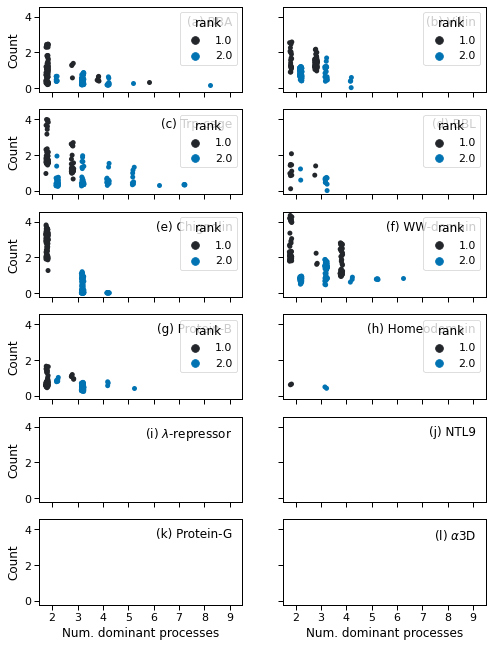

In [10]:
top_2_ts = ts_df.loc[ts_df['rank'] <=2, :]


with sns.plotting_context('paper', font_scale=1.25):
    n_rows, n_cols = 6, 2
    sharey=True
    use_log = True # percentage change in timescale as gradient
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

        
    ylabel = 'Count'
    xlabel = 'Num. dominant processes'
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            tmp = top_2_ts.loc[top_2_ts.protein==label, :]
            
            
            if tmp.shape[0]>1:
                sns.stripplot(data=tmp, x='num_its',y='grad_t',  hue='rank',  order=np.arange(2, 10).astype(int), 
                                   color=funcs.cols[0], ax=ax, dodge=True)
                ax.set_ylabel(None)
                ax.set_xlabel(None)
                
#                 heights = [x.get_height() for x in ax.containers[0]]
#                 labels = [int(x) if x < 5 else '' for x in heights]
#                 ax.bar_label(ax.containers[0], labels)
                
                
            if sharey:
                if j == 0:
                    ax.set_ylabel(ylabel)
            else:
                ax.set_ylabel(ylabel)

            if i == n_rows - 1:
                ax.set_xlabel(xlabel)
            

            ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.95, 0.9), 
                        xycoords='axes fraction', ha='right', va='top', 
                       bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
    